In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate, BatchNormalization, Dropout, MultiHeadAttention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil

2025-08-30 17:06:35.408827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-30 17:06:35.408973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-30 17:06:35.642867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

# Define class labels
class_labels = ['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']

# Path to dataset directory
dataset_dir = "/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment"

# Define new dataset structure
base_dir = "/kaggle/working/potato_leaf_disease_split"
train_dir = os.path.join(base_dir, "Train")
valid_dir = os.path.join(base_dir, "Valid")
test_dir = os.path.join(base_dir, "Test")


In [ ]:
# Create directories
for directory in [train_dir, valid_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Split data (80% train, 10% validation, 10% test)
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
        valid_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # Create category subdirectories
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(valid_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Move images
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
        for img in valid_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(valid_dir, category, img))
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

In [ ]:
# Step 1: Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)


Found 2457 images belonging to 7 classes.
Found 308 images belonging to 7 classes.
Found 311 images belonging to 7 classes.


In [ ]:

# Step 2: Build Model with Transfer Learning and Attention
def build_hybrid_model(input_shape=(224, 224, 3)):
    base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_densenet = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze Pre-trained Layers for Fine-Tuning
    base_resnet.trainable = True
    base_densenet.trainable = True

    input_layer = Input(shape=input_shape)
    resnet_features = base_resnet(input_layer)
    densenet_features = base_densenet(input_layer)

    # Apply Global Average Pooling
    resnet_features = GlobalAveragePooling2D()(resnet_features)
    densenet_features = GlobalAveragePooling2D()(densenet_features)

    # Match feature vector sizes before Attention
    resnet_features = Dense(1024, activation="relu")(resnet_features)
    densenet_features = Dense(1024, activation="relu")(densenet_features)

    # Attention Mechanism
    attention_layer = MultiHeadAttention(num_heads=4, key_dim=256)
    resnet_features_expanded = Reshape((1, 1024))(resnet_features)
    densenet_features_expanded = Reshape((1, 1024))(densenet_features)

    attention = attention_layer(resnet_features_expanded, densenet_features_expanded)
    attention = Reshape((1024,))(attention)

    # Merging features
    merged_features = Concatenate()([resnet_features, densenet_features, attention])

    layer = BatchNormalization()(merged_features)
    layer = Dropout(0.5)(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.4)(layer)
    output = Dense(len(class_labels), activation='softmax')(layer)  # Updated for 7 classes

    model = Model(inputs=input_layer, outputs=output)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:


# Step 3: Train Model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_hybrid = build_hybrid_model()
model_hybrid.summary()

history = model_hybrid.fit(train_generator,
                           validation_data=valid_generator,
                           epochs=25,
                           callbacks=[lr_scheduler])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,098,176 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │    525,312 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1024)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1024)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1024)   │  4,198,400 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1024)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3072)      │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 3072)      │     12,288 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 3072)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  1,573,376 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat

 Total params: 46,878,663 (178.83 MB)

 Trainable params: 46,817,607 (178.59 MB)

 Non-trainable params: 61,056 (238.50 KB)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1756573808.108536     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1756573808.199203     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1756573808.2

45/77 ━━━━━━━━━━━━━━━━━━━━ 22s 710ms/step - accuracy: 0.1401 - loss: 2.9134

W0000 00:00:1756573959.607073     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1756573959.612241     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1515 - loss: 2.8715

W0000 00:00:1756573987.413256     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1756573987.417410     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.1519 - loss: 2.8701 - val_accuracy: 0.1851 - val_loss: 5.6295 - learning_rate: 1.0000e-04
Epoch 2/25


W0000 00:00:1756574019.313332     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1756574019.317647     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 757ms/step - accuracy: 0.2122 - loss: 2.4829 - val_accuracy: 0.1721 - val_loss: 7.7432 - learning_rate: 1.0000e-04
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 761ms/step - accuracy: 0.2813 - loss: 2.2791 - val_accuracy: 0.1851 - val_loss: 14.9790 - learning_rate: 1.0000e-04
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 774ms/step - accuracy: 0.3222 - loss: 2.0850 - val_accuracy: 0.2013 - val_loss: 3.2020 - learning_rate: 1.0000e-04
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 758ms/step - accuracy: 0.4175 - loss: 1.7577 - val_accuracy: 0.2500 - val_loss: 2.4176 - learning_rate: 1.0000e-04
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 761ms/step - accuracy: 0.4646 - loss: 1.5923 - val_accuracy: 0.1883 - val_loss: 3.4804 - learning_rate: 1.0000e-04
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 759ms/step - accuracy: 0.4952 - loss: 1.4777 - val_accuracy: 0.1851 - val_loss: 2.9694 - learning_rate: 1.0000e-04
Epoch 8/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 65s 771ms/step - accuracy: 0.5

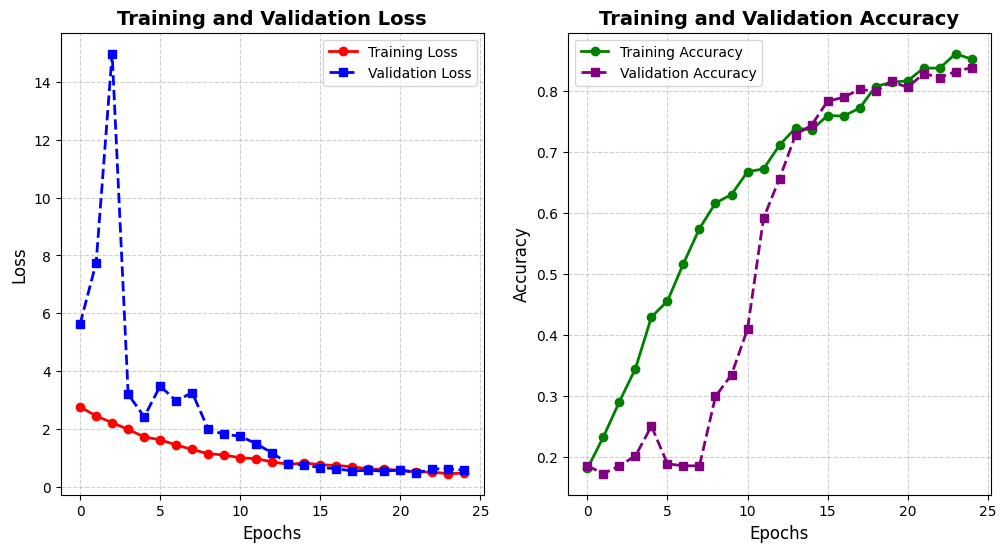

In [ ]:
# Step 5: Training Loss and Accuracy Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', linestyle='-', color='red', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], marker='s', linestyle='--', color='blue', linewidth=2, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='green', linewidth=2, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='s', linestyle='--', color='purple', linewidth=2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:

# Step 4: Evaluate Model
test_loss, test_accuracy = model_hybrid.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8527 - loss: 0.4358 
Test Accuracy: 81.03%


W0000 00:00:1756575586.758502     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1756575586.762692     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:

# Step 5: Compute Metrics
y_pred = model_hybrid.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = test_generator.classes  # True labels

print(classification_report(y_test_classes, y_pred_classes, target_names=class_labels))

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step

W0000 00:00:1756575592.849278     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1756575592.853378     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 950ms/step


W0000 00:00:1756575601.402752     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1756575601.406770     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

    Bacteria       0.84      1.00      0.91        57
       Fungi       0.84      0.81      0.82        75
     Healthy       0.89      0.81      0.85        21
    Nematode       1.00      0.43      0.60         7
        Pest       0.75      0.68      0.71        62
 Phytopthora       0.90      0.77      0.83        35
       Virus       0.77      0.89      0.83        54

    accuracy                           0.82       311
   macro avg       0.86      0.77      0.79       311
weighted avg       0.82      0.82      0.82       311



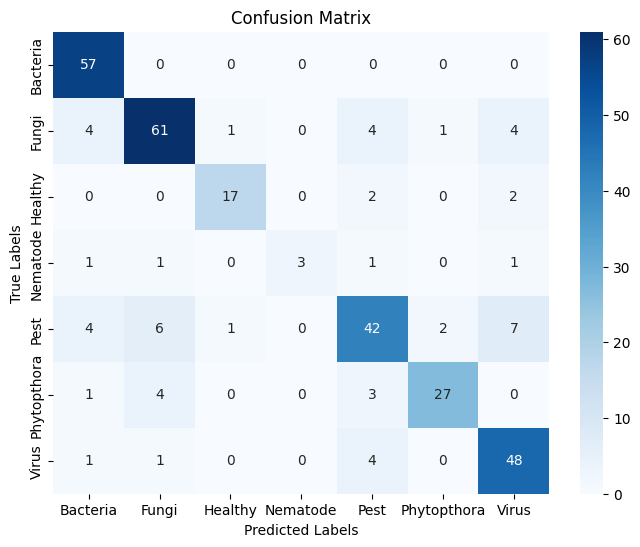

In [ ]:
# Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
